In [1]:
import pandas as pd
cars = pd.read_csv("../data/car-sales-extended-missing-data.csv")
cars.head(5)

,Make,Colour,Odometer (KM),Doors,Price
0,Honda,White,35431.0,4.0,15323.0
1,BMW,Blue,192714.0,5.0,19943.0
2,Honda,White,84714.0,4.0,28343.0
3,Toyota,White,154365.0,4.0,13434.0
4,Nissan,Blue,181577.0,3.0,14043.0


In [2]:
cars.dtypes

Make              object
Colour            object
Odometer (KM)    float64
Doors            float64
Price            float64
dtype: object

In [4]:
cars.isna().sum()

Make             49
Colour           50
Odometer (KM)    50
Doors            50
Price            50
dtype: int64

In [52]:
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

import numpy as np
np.random.seed(42)

# import data, drop missing target vals
cars = pd.read_csv("../data/car-sales-extended-missing-data.csv")
cars.dropna(subset=["Price"], inplace=True)

# split model
X = cars.drop("Price", axis=1)
y = cars["Price"]

# set categories to fill
categorical_features = ["Make", "Colour"]
door_features = ["Doors"]
numerical_features = ["Odometer (KM)"]

# set how to fill categories
categorical_imputer = SimpleImputer(strategy="constant", fill_value="missing")
door_imputer = SimpleImputer(strategy="constant", fill_value=4)
numerical_imputer = SimpleImputer(strategy="mean")

# run imputer, fill categories
imputer = ColumnTransformer([
    ("categorical_imputer", categorical_imputer, categorical_features),
    ("door_imputer", door_imputer, door_features),
    ("mumerical_imputer", numerical_imputer, numerical_features)
])

cars_filled = imputer.fit_transform(X)
cars = pd.DataFrame(cars_filled, 
                   columns = ["Make", "Colour", "Doors", "Odometer (KM)"])

# turn categories into numbers, convert back to dataframe
categories = ["Make", "Colour", "Doors"]
one_hot = OneHotEncoder()
transformer = ColumnTransformer([("one_hot",
                                one_hot,
                                categories)],
                               remainder="passthrough")

transformed_cars = transformer.fit_transform(cars)
X = pd.DataFrame(transformed_cars.toarray())

# set the train / test vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# build model and train
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.21990196728583933

In [53]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

preds = model.predict(X_test)
baseline = evaluate_preds(y_test, preds)

R squared: 21.99%
Mean Abs Error: 5727.89
Mean Sqr Error: 52235124.79


In [54]:
def evaluate_preds(y_test, y_preds):
    """
    Performs evaluation comparison on y_tru lables vs. y_pred labels on a classification."""
    r2 = r2_score(y_true=y_test,
        y_pred=y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    mse = mean_squared_error(y_test, y_preds)
    metric_dict = {"r2": round(r2, 2),
                  "mae": round(mae, 2),
                  "mse": round(mse, 2)}
    print(f"R squared: {r2 * 100:.2f}%")
    print(f"Mean Abs Error: {mae:.2f}")
    print(f"Mean Sqr Error: {mse:.2f}")
       
    return metric_dict
    

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
       "max_depth": [None, 5, 10, 20, 30],
       "max_features": [None, 0.5, "sqrt"],
       "min_samples_split": [2, 4, 6],
       "min_samples_leaf": [1, 2, 4]}

rs_model = RandomizedSearchCV(estimator=model,
                             param_distributions=grid,
                             n_iter=10,
                             cv=5,
                             verbose=2)

rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.5s
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.5s
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; tot

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': [None, 0.5, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]},
                   verbose=2)

In [56]:
rs_model.best_params_

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 5}

In [57]:
rs_preds = rs_model.predict(X_test)
random_search = evaluate_preds(y_test, rs_preds)

R squared: 29.19%
Mean Abs Error: 5610.29
Mean Sqr Error: 47411263.72


In [58]:
grid_2 = {"n_estimators": [10, 1000, 1200],
       "max_depth": [None, 5, 30],
       "max_features": [None, 0.5, "sqrt"],
       "min_samples_split": [2, 6],
       "min_samples_leaf": [1, 4]}

gs_model = GridSearchCV(estimator=model,
                       param_grid=grid_2,
                       cv=5,
                       verbose=2)

gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n

[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.0s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=None,

[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1000; total time=   0.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   1.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.6s
[CV] END max_dep

[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   0.7s
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=5, max_features=None, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.5s
[CV] END max_depth=5, max_features=None, min_sampl

[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.5s
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.4s
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   0.5s
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=0.5, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=0.5, min_samp

[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt,

[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=6, n_estimators=1200; total time=   0.7s
[CV] END max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END max_depth=30, max_features=0.5, min_samp

[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   0.8s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=10; total time=   0.0s
[CV] END max_depth=30, max_feature

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
             param_grid={'max_depth': [None, 5, 30],
                         'max_features': [None, 0.5, 'sqrt'],
                         'min_samples_leaf': [1, 4],
                         'min_samples_split': [2, 6],
                         'n_estimators': [10, 1000, 1200]},
             verbose=2)

In [59]:
gs_model.best_params_

{'max_depth': 5,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [62]:
gs_preds = gs_model.predict(X_test)
grid_search = evaluate_preds(y_test, gs_preds)
grid_search

R squared: 32.18%
Mean Abs Error: 5504.86
Mean Sqr Error: 45409593.62


{'r2': 0.32, 'mae': 5504.86, 'mse': 45409593.62}

<Axes: >

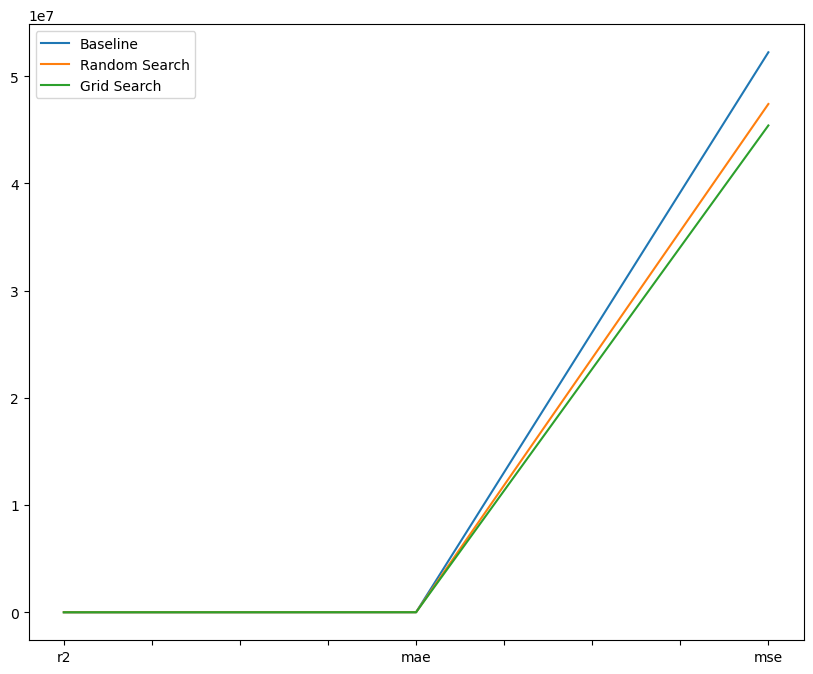

In [63]:
compare = pd.DataFrame({"Baseline": baseline,
                       "Random Search": random_search,
                       "Grid Search": grid_search})

compare.plot(figsize=(10,8))